# EELS SrFeO Project 
## Data Preparation

*Collaboration: M3 Learning at Lehigh University x Dynamic Characterization Group at Drexel University*

September 2019:
> The data provided includes initial state (SrFeO3 with Fe4+) and annealed state (SrFeO2.5 with Fe3+). Total of 90,000 spectra was provided: 
- 2 sets of 10 spectrum images with 300 x 30 spatial coordinates. 
- Each spatial coordinate has 3710 energy channels. 
- For each spectra, the initial energy-loss value is 387.5 eV with energy width of 0.125 eV.
- i.e. \[387.5: 851.25: 0.125\]

### Import Package

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import hyperspy.api as hs
import numpy as np
import pandas as pd
import scipy
import itertools

### Loading Data

Avoid stacking because you will lose access to multi-files metadata

In [75]:
# Loading Initial Data

data_initial = hs.load('raw_data/High-Speed EELS/Initial SIs/*.dm4', signal_type="EELS", stack=False)
#print(data_initial.metadata)
#print(data_initial.axes_manager)

In [76]:
# Loading Annealed Data

data_anneal = hs.load('raw_data/High-Speed EELS/Annealed SIs/*.dm4', signal_type="EELS", stack=False)
#print(data_initial.metadata)
#print(data_initial.axes_manager)

### Dark reference
Software used to collect EELS data has some glitches. Dark reference is provided and must be added to each spectrum.

In [77]:
def add_dark_ref(stacked_data, dark_ref):
    """
    Add dark references to EELS dataset
    
    Parameters
    -----------
    stacked_data: object
        stacked datasets to be corrected
        content access via stacked_data.data (4d array)
    dark_ref: 1d array
        dark reference for correction
    """
    dim = stacked_data[0].data.shape
    for k, i, j in itertools.product(range(len(stacked_data)), range(dim[0]), range(dim[1])):
        stacked_data[k].data[i][j] = np.sum([stacked_data[k].data[i][j],dark_ref.data], axis=0)

In [78]:
# Add dark references

dark_ref = hs.load('raw_data/High-Speed EELS/dark reference.dm4', signal_type="EELS")
add_dark_ref(data_initial, dark_ref)
add_dark_ref(data_anneal, dark_ref)

### Background Subtraction 

Jamie suggested performing background subtraction based on power law fit. $I = A*E^r$
* I is the measured intensity, 
* A is a constant
* E is the energy-loss value (eV)
* r is an exponent (usually around 3)

Select an energy window (around 50 eV wide) at around a few eV before the region of interest to fit A and r.

#### Resources
https://github.com/trygvrad/RNN-on-EELS-data/blob/master/EELScodes \
https://scipy-cookbook.readthedocs.io/items/FittingData.html \
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

In [79]:
'''
Background Subtraction & Filter noise (Savizky-Golay Filter)
'''
import scipy.optimize # curve_fit
from scipy.fftpack import fft

def scaledExp(x,a,b):
    return a*np.exp((np.array(x))*b)

def subtractExpBackground(data1,xrange=None):
    data2 = np.float32(np.copy(data1))
    x = range(data1.shape[2])
    # fit over the entire spectra by default
    if type(xrange) == type(None):
        xrange = x 
    for i in range(data1.shape[0]):
        for j in range(data1.shape[1]):
            popt, pcov = scipy.optimize.curve_fit(scaledExp,xrange,data2[i,j,xrange], p0 = [4.19082741e+02, -1.93625569e-03])
            data2[i,j] = data2[i,j]-scaledExp(x,popt[0],popt[1])
            # print(popt)
    return data2

def subtract_bckgrnd_and_filter(data):
    backgroundregion = np.arange(400,1000,1)  # this is approximately 50eV wide, over the region before ROI
    for k,spectra in enumerate(data): 
        data[k].data = subtractExpBackground(spectra.data,backgroundregion)
        data[k].data = scipy.signal.savgol_filter(data[k].data, 51, 3) # window size 50, polynomial order 3

In [80]:
subtract_bckgrnd_and_filter(data_initial)
subtract_bckgrnd_and_filter(data_anneal)

### Savitzky–Golay Noise Filter

In [83]:
def filter_savgol(stacked_data):
    """
    Apply Savitzky–Golay filter to reduce noise
    
    Parameters
    -----------
    stacked_data: object
        stacked datasets to be corrected
        content access via stacked_data.data (4d array)
    """
    for k,spectra in enumerate(stacked_data):
        # Savitzky–Golay filter with window size 51, polynomial order 3
        stacked_data[k].data = scipy.signal.savgol_filter(stacked_data[k].data, 51, 3) 

In [84]:
# Apply SavGol filter

filter_savgol(data_initial)
filter_savgol(data_anneal)

### Fast Fourier Transform 

You can plot this out. What you will see in this dataset however is that there is no real patterns of noise that must be removed i.e. after doing FTT, you may be able to pick out certain features in the graph that may correspond to noise to be removed.

>"The output of the FFT is a complex vector containing information about the frequency content of the signal. The magnitude tells you the strength of the frequency components relative to other components. The phase tells you how all the frequency components align in time." ~ Mathworks.com

### Downsampling

Done to reduce noise. Trying out if it works.

#### Resources
https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.downscale_local_mean

In [85]:
from scipy.signal import resample

def downsample(stacked_data, N_resampled):
    """
    down sampling the data
    
    Parameters
    -----------
    stacked_data: object
        stacked datasets to be corrected
        content access via stacked_data.data (4d array)   
    N_resampled: int
        number of samples in the resampled set
    """
    dim = stacked_data[0].data.shape
    for k,sp in enumerate(stacked_data):
        stacked_data[k].resample = np.zeros((dim[0],dim[1], N_resampled))
    for k, i, j in itertools.product(range(len(stacked_data)), range(dim[0]), range(dim[1])):
        stacked_data[k].resample[i][j] = resample(stacked_data[k].data[i][j][:], N_resampled)      

In [86]:
N_resampled = 1500

downsample(data_initial, N_resampled)
downsample(data_anneal, N_resampled)

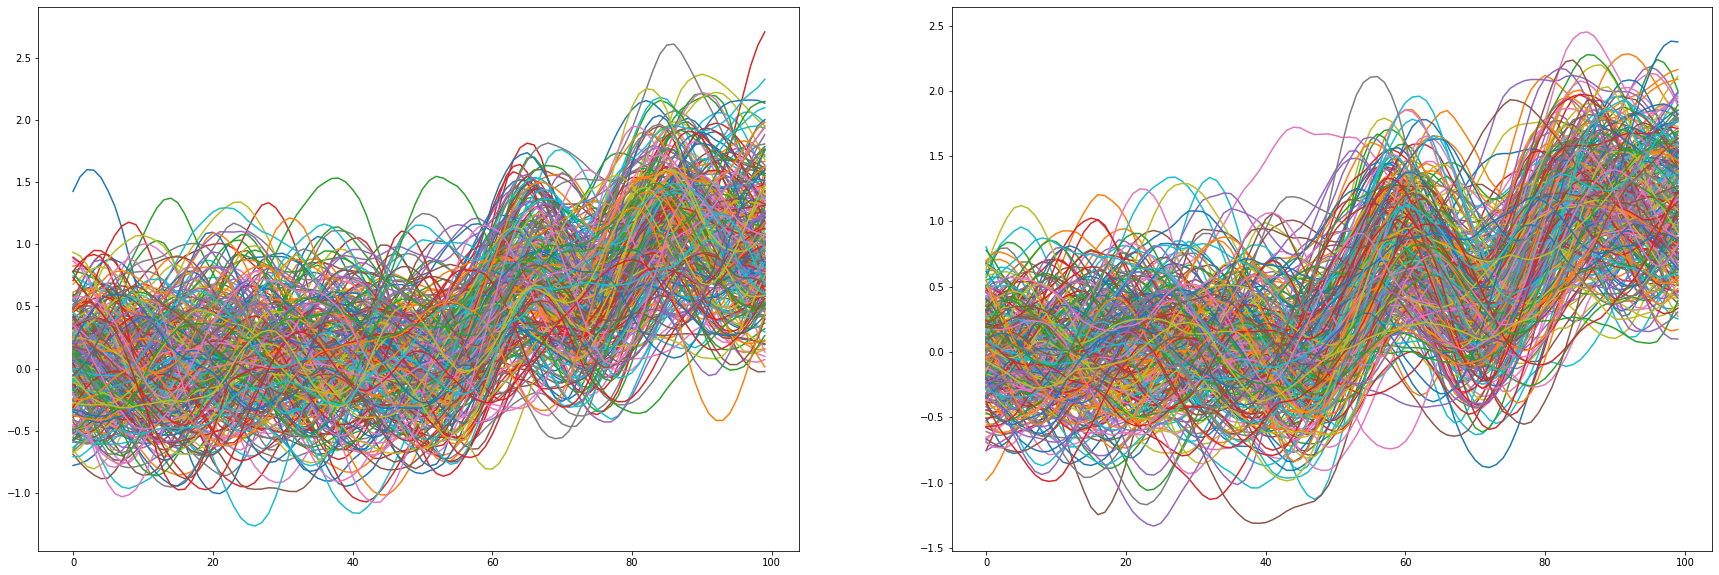

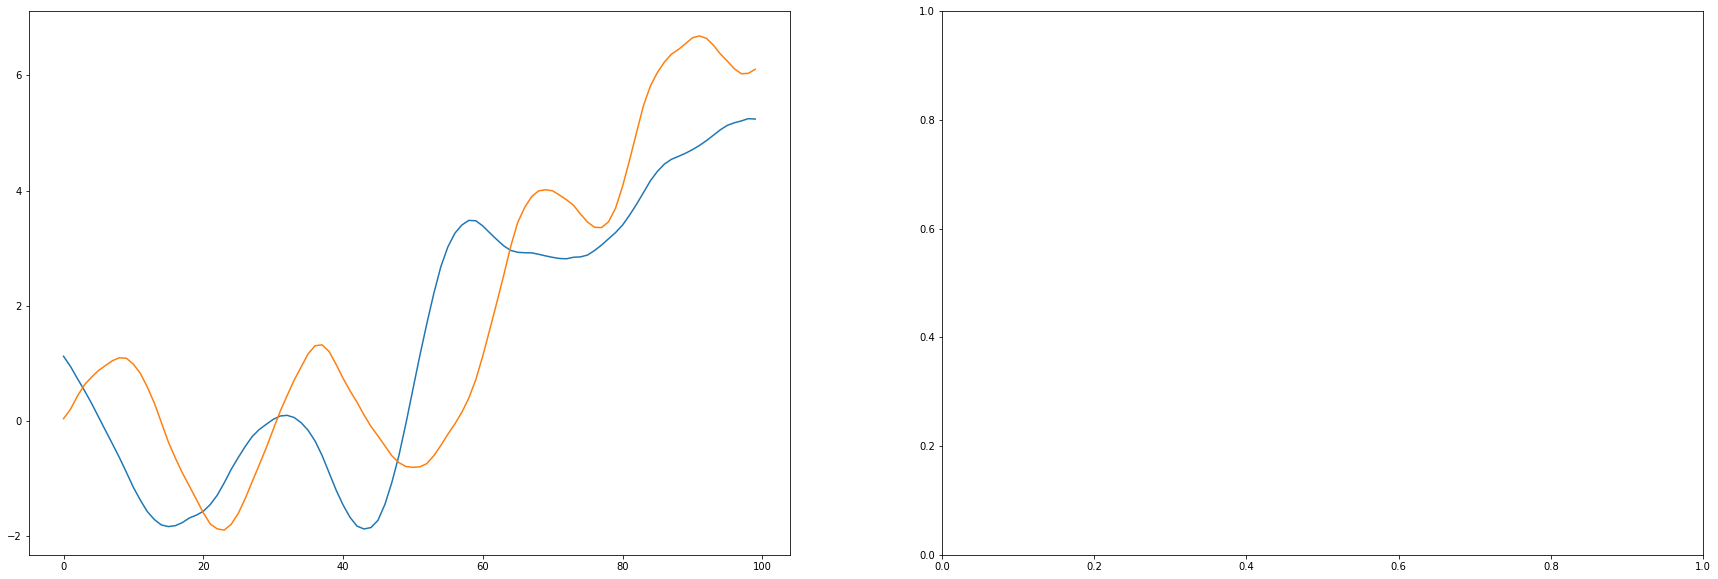

In [87]:
f,(ax1,ax2) = plt.subplots(1,2, figsize=(30,10))
for i in data_anneal[3].resample[20]:
    ax1.plot(i[400:500])
for i in data_initial[3].resample[20]:
    ax2.plot(i[400:500])
    
f,(ax1,ax2) = plt.subplots(1,2, figsize=(30,10))
ax1.plot(np.sum(data_initial[3].resample[20][30:35], axis=0)[400:500])
ax1.plot(np.sum(data_anneal[3].resample[20][30:35], axis=0)[400:500])

### Visualize aggregated signals

Visualizing what we would expect from combined signals. It's pretty to look at when SNR is high!

In [88]:
'''
aggregate data along 2D space
'''
def aggre_plot(data, N, name:str=''):
    import math
    N_0 = data[0].data.shape[2]
    N_1 = 1500  # number resampled (have to match previous resampling rate)
    anly_range = 100
    
    exp_adjusted_data = {}
    aggregated_data_x = {}
    aggregated_data_xy = {}
    for k,spectra in enumerate(data):
        exp_adjusted_data[k] = spectra.resample
        aggregated_data_x[k] = sum(exp_adjusted_data[k]).transpose()
        aggregated_data_xy[k] = np.sum(aggregated_data_x[k],axis=1)
        #print("Shape of XY aggregate: ", str(k), str(aggregated_data_xy[k].shape))

    '''
    plot aggregated spectral data
    '''
    new_xaxis = np.linspace(387.5, 783.75, num=N)  # This is the range of energy loss given by the EELS machine
    for k,key in enumerate(aggregated_data_xy):
        ax1.plot(new_xaxis, aggregated_data_xy[key], label='spectra '+str(key))
        ax2.plot(aggregated_data_xy[key][math.ceil(1100/N_0*N_1):math.ceil((1100+anly_range)/N_0*N_1)], label='O K-edge'+name) # O K-edge 
        ax3.plot(aggregated_data_xy[key][math.ceil(2550/N_0*N_1):math.ceil((2700+anly_range)/N_0*N_1)], label='Fe L-edge'+name) # Fe L-edge
        #ax2.plot(corrected_xaxis[1000:1500], aggregated_data_xy[key][1000:1500], label='O K-edge') # O K-edge 
        #ax3.plot(corrected_xaxis[2500:3000], aggregated_data_xy[key][2500:3000], label='Fe L-edge') # Fe L-edge
        if k>5:
            break

    '''
    configure the plot
    '''
    ax1.set_title("Average Energy Loss")
    #ax1.title.set_text('Overall')
    #ax2.title.set_text('Over O peaks')
    #ax3.title.set_text('Over Fe Peaks')
    #ax4.title.set_text('Except the first few eV')
    plt.xlabel("Energy Loss (eV)")
    plt.ylabel("counts")
    #plt.legend()

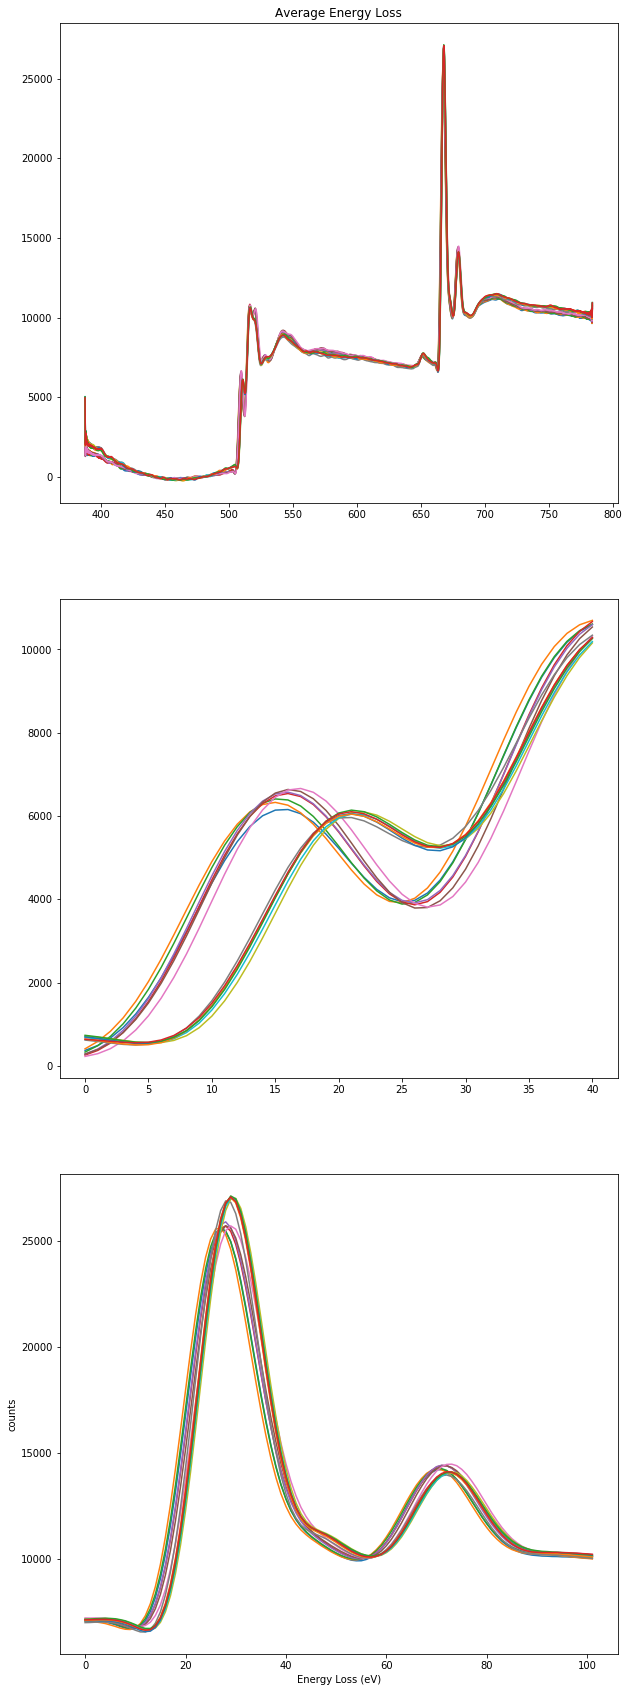

In [89]:
fig, (ax1,ax2,ax3) = plt.subplots(3, figsize=(10,30))
aggre_plot(data_initial, N_resampled, name='Initial')
aggre_plot(data_anneal, N_resampled, name='Anneal')
plt.show()